# Liesel-GAM Demo Notebook

## Setup and Imports

In [7]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [8]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

In [9]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


## Model Definition

### Setup response model

In [10]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [11]:
loc += tb.rs("income", cluster="district", noncentered=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


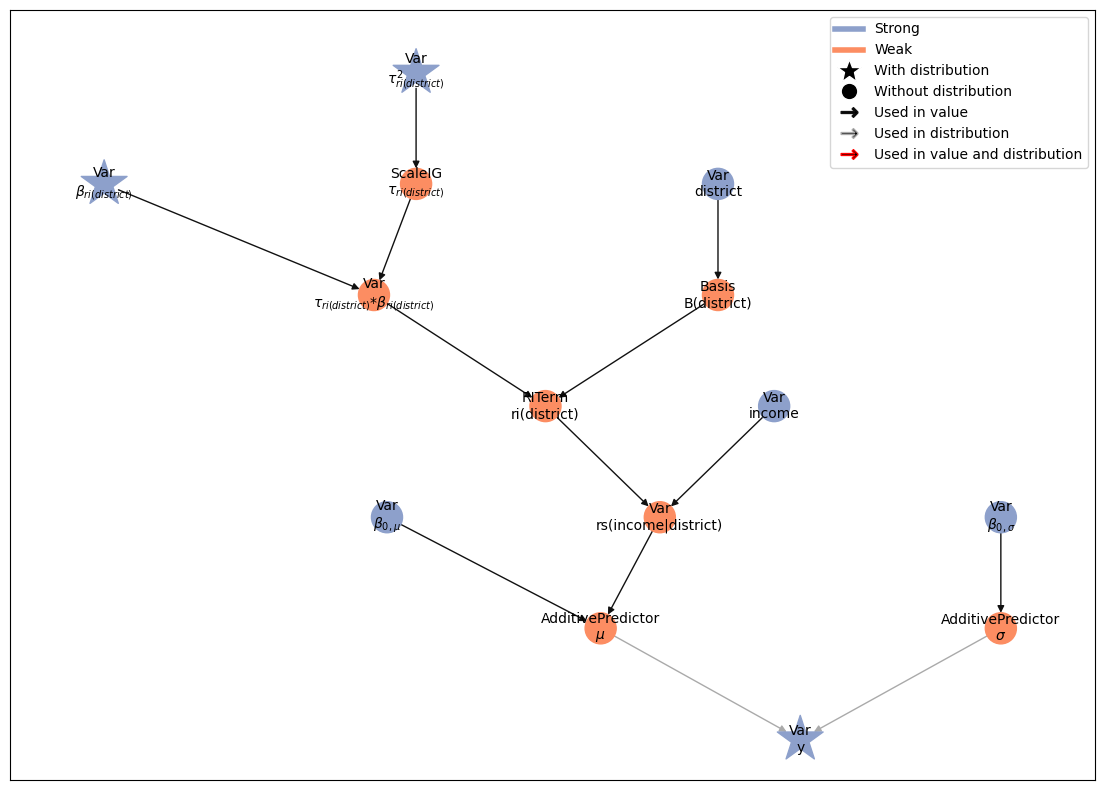

In [12]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [13]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{ri(district)}$', '$\\tau^2_{ri(district)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  5.19chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1269.08chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1300.36chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.e

### MCMC summary

In [14]:
summary = gs.Summary(results)
summary

Parameter summary:

                                  kernel       mean        sd     q_0.05  \
parameter               index                                              
$\beta_{0,\mu}$         ()     kernel_01  35.641788  2.660894  31.326024   
$\beta_{0,\sigma}$      ()     kernel_00   2.795326  0.127449   2.589178   
$\beta_{ri(district)}$  (0,)   kernel_02  -0.301614  0.984205  -1.916711   
                        (1,)   kernel_02  -0.233232  0.980959  -1.806448   
                        (2,)   kernel_02  -0.069094  0.952425  -1.624893   
                        (3,)   kernel_02  -0.013282  0.992705  -1.630736   
                        (4,)   kernel_02   0.100128  0.963587  -1.513546   
                        (5,)   kernel_02  -0.137877  0.961959  -1.698978   
                        (6,)   kernel_02  -0.307671  1.055974  -2.051414   
                        (7,)   kernel_02   0.023181  0.941608  -1.508942   
                        (8,)   kernel_02  -0.061228  0.960520  -1.675307   
                        (9,)   kernel_02  -0.024510  0.985577  -1.666728   
                        (10,)  kernel_02   0.204583  1.017235  -1.472511   
                        (11,)  kernel_02   0.142285  0.996062  -1.517356   
                        (12,)  kernel_02   0.075788  0.966310  -1.524825   
                        (13,)  kernel_02   0.140268  0.976380  -1.460080   
                        (14,)  kernel_02   0.092647  0.983453  -1.511648   
                        (15,)  kernel_02   0.139801  1.008027  -1.539134   
                        (16,)  kernel_02  -0.018134  0.992689  -1.652446   
                        (17,)  kernel_02   0.065019  0.971960  -1.549085   
                        (18,)  kernel_02   0.152770  1.005012  -1.467372   
                        (19,)  kernel_02  -0.573647  0.995345  -2.160543   
                        (20,)  kernel_02   0.022746  0.970978  -1.559333   
                        (21,)  kernel_02  -0.024222  0.956663  -1.593772   
                        (22,)  kernel_02  -0.226084  0.957597  -1.793531   
                        (23,)  kernel_02  -0.006214  0.976462  -1.606798   
                        (24,)  kernel_02   0.184319  1.023363  -1.457075   
                        (25,)  kernel_02   0.036074  0.985606  -1.584563   
                        (26,)  kernel_02   0.151243  1.014296  -1.488402   
                        (27,)  kernel_02   0.134815  0.990825  -1.503064   
                        (28,)  kernel_02   0.181175  0.996415  -1.441874   
                        (29,)  kernel_02   0.337263  1.014541  -1.348902   
                        (30,)  kernel_02  -0.251730  0.974133  -1.804864   
                        (31,)  kernel_02  -0.207230  0.977866  -1.795502   
                        (32,)  kernel_02   0.057935  0.989701  -1.552554   
                        (33,)  kernel_02  -0.134031  0.989227  -1.754262   
                        (34,)  kernel_02   0.031494  0.967403  -1.570723   
                        (35,)  kernel_02  -0.255008  0.975782  -1.797680   
                        (36,)  kernel_02   0.037169  0.936235  -1.516161   
                        (37,)  kernel_02   0.154943  1.006298  -1.520165   
                        (38,)  kernel_02  -0.205768  0.973961  -1.805580   
                        (39,)  kernel_02  -0.340555  0.935324  -1.853423   
                        (40,)  kernel_02  -0.258217  0.976654  -1.811182   
                        (41,)  kernel_02  -0.275412  0.966672  -1.818677   
                        (42,)  kernel_02  -0.004608  0.969241  -1.597250   
                        (43,)  kernel_02  -0.108808  0.957377  -1.645057   
                        (44,)  kernel_02  -0.073190  0.980800  -1.676059   
                        (45,)  kernel_02  -0.252742  0.992148  -1.839124   
                        (46,)  kernel_02  -0.098325  0.972901  -1.664110   
                        (47,)  kernel_02  -0.045655  0.989570  -1.648863   
                        (48,

## Plots

In [15]:
samples = results.get_posterior_samples()

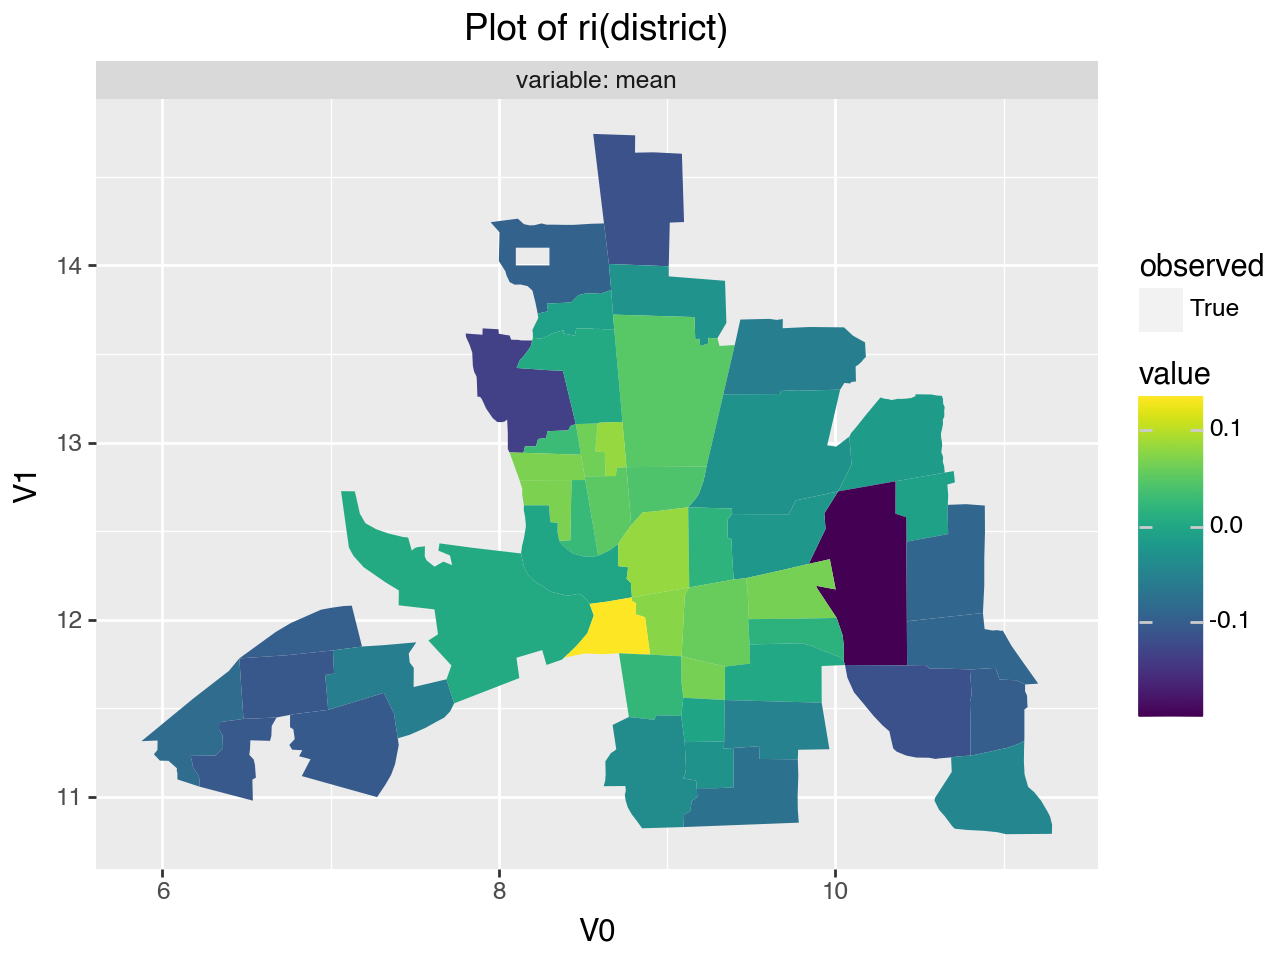

In [16]:
gam.plot_regions(model.vars["ri(district)"], samples, polys=polys)

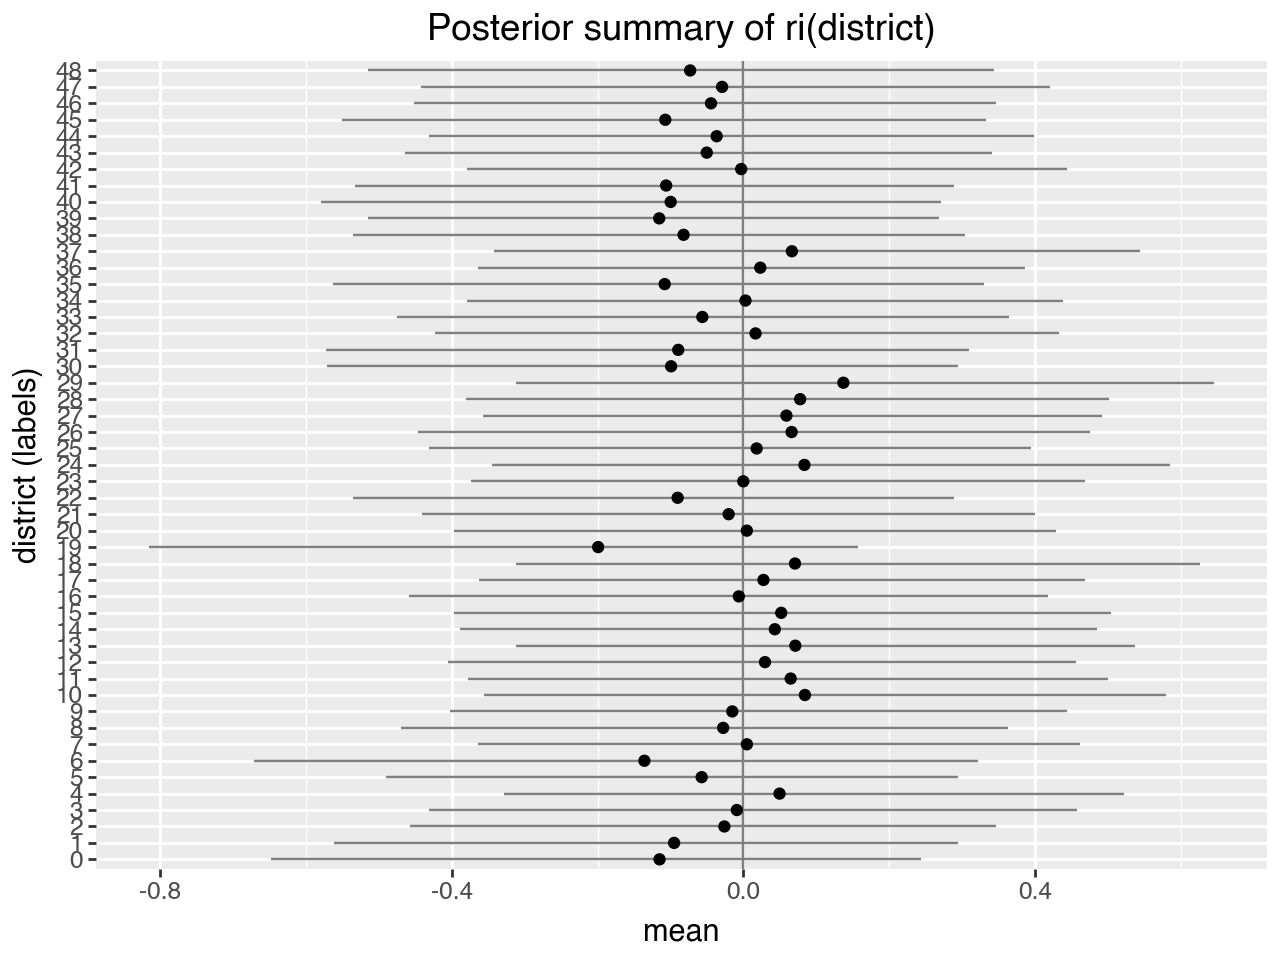

In [17]:
gam.plot_forest(model.vars["ri(district)"], samples)

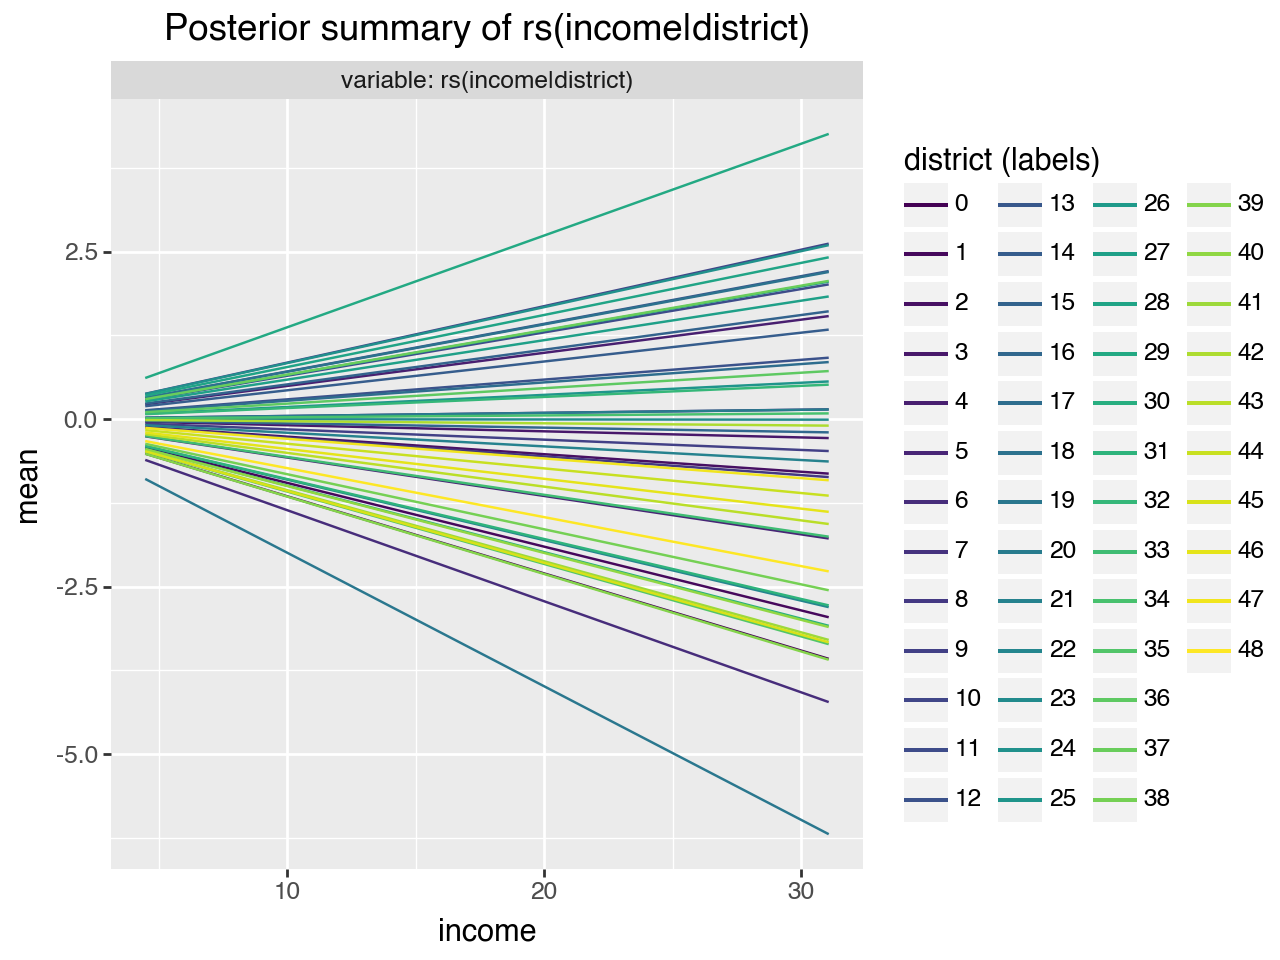

In [18]:
gam.plot_1d_smooth_clustered(
    clustered_term=model.vars["rs(income|district)"],
    samples=samples,
    ngrid=10,
)